## Description:
The problem is to generate Monet-like pictures based on real photos. 

This is oversimplified so lets get the details up:
The dataset contains 300 pictures of Monet's paintings. In addition it has 7000 + real photos with diverse motives. All pictures (paintings and real photos) have a size of 256 x 256 and they are in color (3 channels)

We have to transfer the style found in the painting to the real photos.

To do so we have to separate the things that are the "content" of the paintings from the "style" of the paintings and then apply the "style" to the real photos.

### References:

This paper is the based of most of the examples I found about similar problems of transfering "style" from one image to another
https://arxiv.org/abs/1611.07004

The paper's approach is to tackle the fact that we dont have similar pictures with different styles that we can easily use for training, but we have "unpaired picture sets" where the pictures with the "style" we want to transfer does not hva similar counterparts on the dataset the "style" will be transfer to. 

There are several approaches: one is to create a conditional GAN like the authors suggest. This is the implementation found here: https://www.tensorflow.org/tutorials/generative/pix2pix

This kind of GAN can be susceptible to mode collapse and it can be avoided. Some suggestion are presented in this article: https://www.linkedin.com/advice/1/how-do-you-avoid-mode-collapse-when-generating

However I decided to go for a cycleGan, where there are two generators and to discriminators working in cycles. This means that we train in cycles. i.e. 

We take a photo convert it to a painting, train the generator and discriminator for paintings and convert the generated painting back to photo and compare the result with the original.

There are many examples of it and I followed these tutorials:
https://www.tensorflow.org/tutorials/generative/cyclegan https://keras.io/examples/generative/cyclegan/
https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

And for convolution problems: https://distill.pub/2016/deconv-checkerboard/

# Strategy:


The steps to follow are:
1. Load the data
2. Do some general EDA and preprocessing 
3. Build the generator and the discriminator
4. Define the generator's and discriminator's losses
5. Define the optimizers for each generator and discriminator
6. Train the model
7. Generate some images
8. Loop through the photo files, generate the images and zip them


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    counter = 0
    for filename in filenames:
        counter += 1
        if counter >= 10:
            break
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gan-getting-started/monet_jpg/f4413e97bd.jpg
/kaggle/input/gan-getting-started/monet_jpg/7341d96c1d.jpg
/kaggle/input/gan-getting-started/monet_jpg/de6f71b00f.jpg
/kaggle/input/gan-getting-started/monet_jpg/99d94af5dd.jpg
/kaggle/input/gan-getting-started/monet_jpg/99a51d3e25.jpg
/kaggle/input/gan-getting-started/monet_jpg/d05cab011d.jpg
/kaggle/input/gan-getting-started/monet_jpg/4e05523825.jpg
/kaggle/input/gan-getting-started/monet_jpg/c68c52e8fc.jpg
/kaggle/input/gan-getting-started/monet_jpg/40d7d18ad3.jpg
/kaggle/input/gan-getting-started/photo_tfrec/photo12-352.tfrec
/kaggle/input/gan-getting-started/photo_tfrec/photo11-352.tfrec
/kaggle/input/gan-getting-started/photo_tfrec/photo05-352.tfrec
/kaggle/input/gan-getting-started/photo_tfrec/photo08-352.tfrec
/kaggle/input/gan-getting-started/photo_tfrec/photo18-352.tfrec
/kaggle/input/gan-getting-started/photo_tfrec/photo06-352.tfrec
/kaggle/input/gan-getting-started/photo_tfrec/photo17-352.tfrec
/kaggle/input/gan-get

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np


2024-04-13 12:43:12.407781: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 12:43:12.407876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-13 12:43:12.536980: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## First load the data using TFRecords

In [4]:
# I will follow this tutorial to load the dataset https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

monet_path = '/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec'
photo_path = '/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec'

monet_filenames = tf.io.gfile.glob(monet_path)
print('Number Monet files: ', len(monet_filenames))

photo_filenames = tf.io.gfile.glob(photo_path )
print('Number photo files: ', len(photo_filenames))

Number Monet files:  5
Number photo files:  20


In [5]:
# This function decodes the image from the tfrecord
IMAGE_SIZE = [256, 256]
IMAGE_SHAPE = [256, 256, 3]

def decode_image(image_record):
    image = tf.image.decode_jpeg(image_record, channels= 3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

In [6]:
# First read the tf record and then from the record get the image. It as relatively easy to understand TFRecords from the information from the tutorial
def get_image(record):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    tf_record = tf.io.parse_single_example(record, tfrecord_format)
    image = decode_image(tf_record['image'])
    return image

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    mapped_dataset = dataset.map(get_image, num_parallel_calls=AUTOTUNE)
    return mapped_dataset

In [8]:
# Crate two datasets one for paintings and another of photos
monet_ds = load_dataset(monet_filenames, labeled=True).batch(1)
photo_ds = load_dataset(photo_filenames, labeled=True).batch(1)

## Some Basic EDA

In [9]:
# Just to have an idea how many images I have and if the number of images from the tfrecords are the same as the number of jpeg files too
def number_of_records(dataset):
    return sum(1 for _ in dataset)

print('Number of records in Monet dataset: ', number_of_records(monet_ds))
print('Number of records in Photo dataset: ', number_of_records(photo_ds))

monet_jpg_path = '/kaggle/input/gan-getting-started/monet_jpg/*.jpg'
photo_jpg_path = '/kaggle/input/gan-getting-started/photo_jpg/*.jpg'

monet_filenames_jpg = tf.io.gfile.glob(monet_jpg_path)
print('Number Monet files: ', len(monet_filenames_jpg))

photo_filenames_jpg = tf.io.gfile.glob(photo_jpg_path )
print('Number photo files: ', len(photo_filenames_jpg))

Number of records in Monet dataset:  300
Number of records in Photo dataset:  7038
Number Monet files:  300
Number photo files:  7038


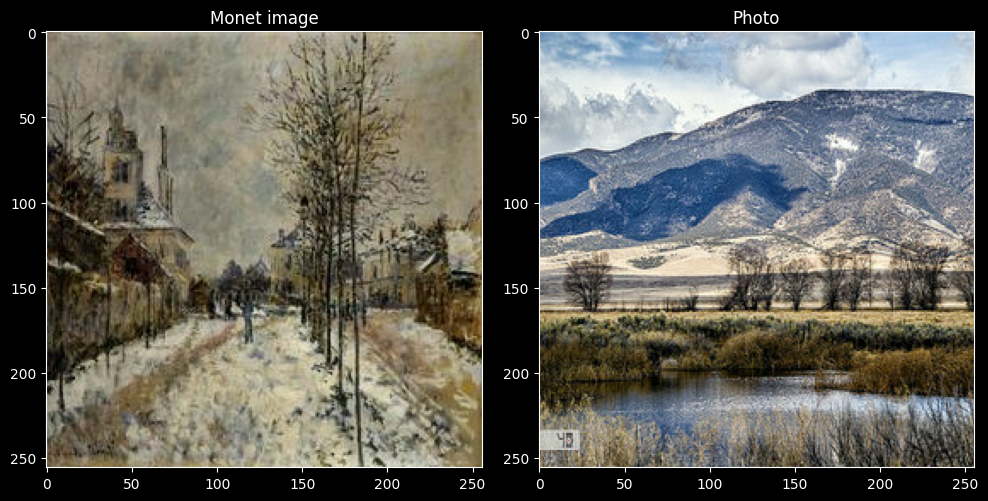

In [102]:
# Visualize some pictures
image_monet = next(iter(monet_ds))
image_photo = next(iter(photo_ds))

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(image_monet[0] * 0.5 + 0.5)
axes[0].set_title('Monet image')

axes[1].imshow(image_photo[0] * 0.5 + 0.5)
axes[1].set_title('Photo')

plt.style.use('dark_background')
plt.tight_layout()
plt.show()


I am not planning to clean the dataset any further. The pictures when imported are resized to the right size and number of channels

## Model architecture

The model is basically two generators and two discriminators that are trained in a cycle. 

The components of the cycle GAN are: 
1. Monet-generator: takes photos and convert them to Monet-like paintings
2. Monet-discriminator: takes the generated Monet-like painting and tries to determine if it is real or fake
3. Photo-generator: takes Monet paintings and convert them to realistic photos
4. Photo-discriminator: takes the generated realistic photo and tries to deterine if it is real or fake

Both generators have the same architecture that is based on a Encoder-Decoder pair. 
Both discriminators have the same architecture between them. 


### Build the generator

In [11]:
OUTPUT_CHANNELS = 3

In [12]:
# Define the block for the encoder. Each encoder block is just a convolutional layer,
# a normalization layer (optional) and a leaky relu activation layer

def encoder_block(filters, size, apply_norm= True):
    initializer = tf.random_normal_initializer(0., 0.02)
    # added this
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    encoder = tf.keras.Sequential()
    encoder.add(tf.keras.layers.Conv2D(
        filters, 
        size,
        strides=2,
        padding='same',
        kernel_initializer = initializer, 
        use_bias=False
        )
    )
    if apply_norm:
        encoder.add(tf.keras.layers.GroupNormalization(
            gamma_initializer=gamma_init,
            groups=-1
            )
        )
        # encoder.add(tf.keras.layers.BatchNormalization())
        
    encoder.add(tf.keras.layers.LeakyReLU())
    return encoder

In [13]:
encoder_tester = encoder_block(3, 4)
encoding_result = encoder_tester(tf.expand_dims(image_monet[0], 0))
print(encoding_result.shape)

(1, 128, 128, 3)


In [14]:
# Define the block for the decoder. Each decoder block is a transpose convolutional layer,
# a normalization layer, a dropout layer (optional) and a relu activation layer

def decoder_block(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    # added this
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    decoder = tf.keras.Sequential()
    decoder.add(tf.keras.layers.Conv2DTranspose(
        filters, 
        size,
        strides=2,
        padding='same',
        kernel_initializer = initializer, 
        use_bias=False
        )
    )
    decoder.add(tf.keras.layers.GroupNormalization(
            gamma_initializer=gamma_init,
            groups=-1
            )
        )
    #decoder.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        decoder.add(tf.keras.layers.Dropout(0.5))
        
    decoder.add(tf.keras.layers.ReLU())
    return decoder

In [15]:
decoder_tester = decoder_block(3, 4)
decoding_result = decoder_tester(encoding_result)
print(decoding_result.shape)

(1, 256, 256, 3)


In [16]:
def build_generator():
    inputs = tf.keras.layers.Input(shape=IMAGE_SHAPE)
    encoding = [
        encoder_block(64, 4, apply_norm=False),
        encoder_block(128, 4),
        encoder_block(256, 4),
        encoder_block(512, 4),
        encoder_block(512, 4),
        encoder_block(512, 4),
        encoder_block(512, 4),
        encoder_block(512, 4)
    ]
    
    decoding = [
        decoder_block(512, 4, apply_dropout=True),
        decoder_block(512, 4, apply_dropout=True),
        decoder_block(512, 4, apply_dropout=True),
        decoder_block(512, 4),
        decoder_block(256, 4),
        decoder_block(128, 4),
        decoder_block(64, 4),
    ]
    
    initializer = tf.random_normal_initializer(0., 0.2)
    last = tf.keras.layers.Conv2DTranspose(
        OUTPUT_CHANNELS, 4,
        strides=2,
        padding='same',
        kernel_initializer = initializer,
        activation='tanh'
    )
    
    # -------------------------------------
    # I tried to change the tranpose layer for upsampling and a normal convolutional layer
    # Change to upsampling
    # upsampling = tf.keras.layers.UpSampling2D(size=(2, 2))
    # Convolutional layer
    # conv = tf.keras.layers.Conv2D(OUTPUT_CHANNELS, 3, strides=1, padding='same', kernel_initializer=initializer)
    # Tanh activation
    # activation = tf.keras.layers.Activation('tanh')
    # -------------------------------------
    
    x = inputs
    
    # build encoder part + skip connnections:
    skips = []
    for encode in encoding:
        x = encode(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    
    # build decoder part and connect skip connections
    for decode, skip in zip(decoding, skips):
        x = decode(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    
    
    outputs = last(x)
   
    # -------------------------------------
    # upsample = upsampling(x)
    # convolution = conv(upsample)
    # last = activation(convolution)
    # outputs = last
    # -------------------------------------
    
    return tf.keras.Model(inputs = inputs, outputs = outputs)
        

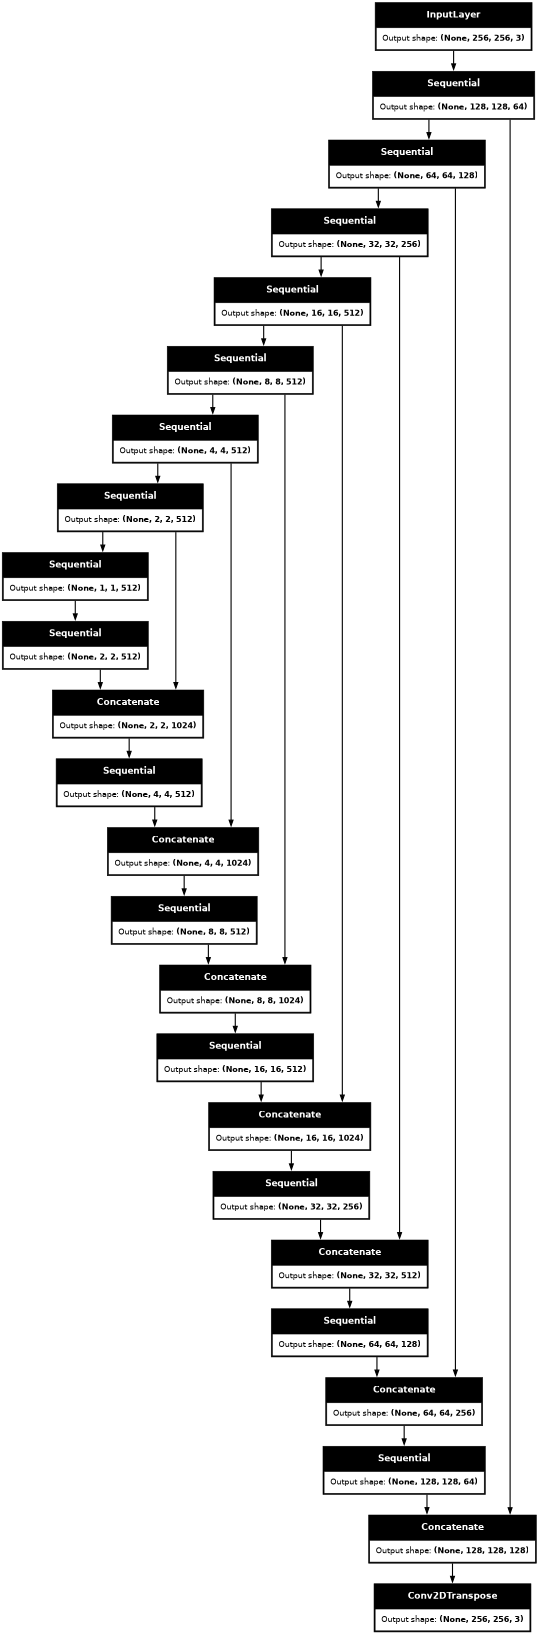

In [17]:
generator = build_generator()
# commented to avoid the submission to have a png file extra
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=40)

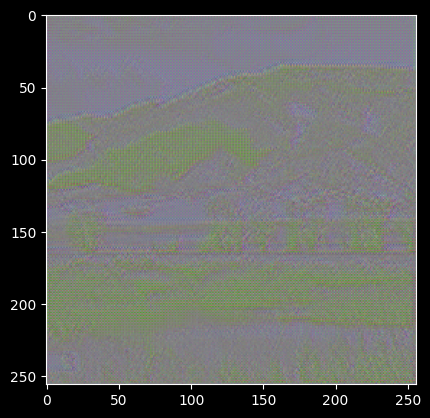

In [18]:
# Test generator (good idea to test often)
output = generator(image_photo[0][tf.newaxis, ...], training=False)
plt.imshow(output[0, ...]* 0.5 + 0.5)

### Build the discriminator

In [19]:
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.2)
    # added this:
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    photos = tf.keras.layers.Input(shape=IMAGE_SHAPE, name='photo_image')
 
    x = photos
    encode1 = encoder_block(64, 4, False)(x)
    encode2 = encoder_block(128, 4)(encode1)
    encode3 = encoder_block(256, 4)(encode2)
    
    zero_1 = tf.keras.layers.ZeroPadding2D()(encode3)
    conv = tf.keras.layers.Conv2D(
        512, 4,
        strides=1,
        kernel_initializer = initializer,
        use_bias = False
        )(zero_1)
    norm = tf.keras.layers.GroupNormalization(
            gamma_initializer=gamma_init,
            groups=-1
            )(conv)
    #norm = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm)
    zero_2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(
        1, 4,
        strides=1,
        kernel_initializer = initializer
        )(zero_2)
    return tf.keras.Model(inputs=photos, outputs=last)

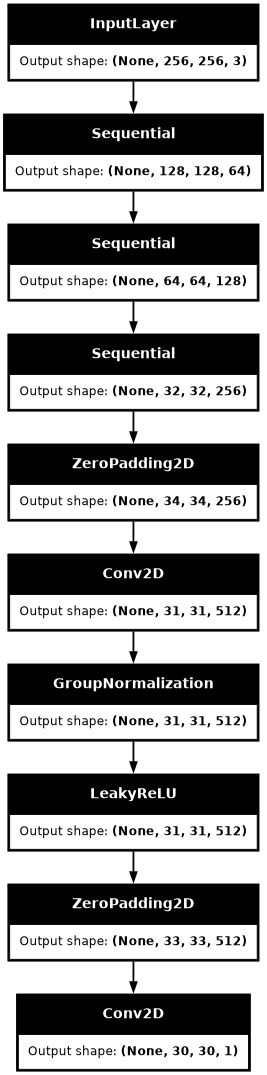

In [20]:
discriminator = build_discriminator()
generator = build_generator()
# commented to avoid the submission to have a png file extra
#tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi= 64)

In [22]:
# Define the generators and discriminators:
strategy = tf.distribute.get_strategy()
with strategy.scope():
    monet_generator = build_generator()
    photo_generator = build_generator()
    
    monet_discriminator = build_discriminator()
    photo_discriminator = build_discriminator()

In [23]:
# Define Cycle GAN:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator, 
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle = 10
    ): 
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # For training the generators
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
            
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
            
            auto_monet = self.m_gen(real_monet, training=True)
            auto_photo = self.p_gen(real_photo, training=True)
            
            # For training the discriminators
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)
            
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            
            # Check generator losses
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            
            # Check total cycle consistency loss:
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            # Check total generator loss:
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, auto_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, auto_photo, self.lambda_cycle)
            
            # Check discriminator loss:
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
            
            # Calculate the gradients:
            monet_gen_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
            photo_gen_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
            
            monet_disc_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
            photo_disc_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)
            
            # Apply gradients to optimizer
            self.m_gen_optimizer.apply_gradients(zip(monet_gen_gradients, self.m_gen.trainable_variables))
            self.p_gen_optimizer.apply_gradients(zip(photo_gen_gradients, self.p_gen.trainable_variables))
            
            self.m_disc_optimizer.apply_gradients(zip(monet_disc_gradients, self.m_disc.trainable_variables))
            self.p_disc_optimizer.apply_gradients(zip(photo_disc_gradients, self.p_disc.trainable_variables))
        
            
            return {
                "monet_gen_loss": total_monet_gen_loss,
                "photo_gen_loss": total_photo_gen_loss,
                "monet_disc_loss": monet_disc_loss,
                "photo_disc_loss": photo_disc_loss  
            }

## Define the generator and discriminator losses

In [24]:
# Define the generator loss:

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction = tf.keras.losses.Reduction.NONE)

with strategy.scope():
    def generator_loss(generated_output):
        gan_loss = loss_object(tf.ones_like(generated_output), generated_output)  
        return gan_loss
    

In [25]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        l1_loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return LAMBDA * l1_loss

In [26]:
with strategy.scope():
    def identity_loss(real_image, auto_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - auto_image))
        return LAMBDA * 0.5 * loss

In [27]:
# Define discriminator loss:
with strategy.scope():
    def descriminator_loss(disc_real_output, dis_generated_output):
        real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    
        generated_loss = loss_object(tf.zeros_like(dis_generated_output), dis_generated_output)
    
        total_disc_loss = real_loss + generated_loss
    
        return total_disc_loss * 0.5

## Define the optimizers for the discriminator and generator

In [28]:
# Define optimizers
with strategy.scope(): 
    monet_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    monet_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [29]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator
    )
    
    cycle_gan_model.compile(
        m_gen_optimizer = monet_gen_optimizer,
        p_gen_optimizer = photo_gen_optimizer,
        m_disc_optimizer = monet_disc_optimizer,
        p_disc_optimizer = photo_disc_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = descriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )
    

I did some hyperparameter tuning manually....
* Different the learning rate from 1ex-4 to 5xe-4
* Different the number of epochs (10, 20, 25, 30 and finally 50)
* Used Batch Normalization insted of Group Normalization
* Some results:  
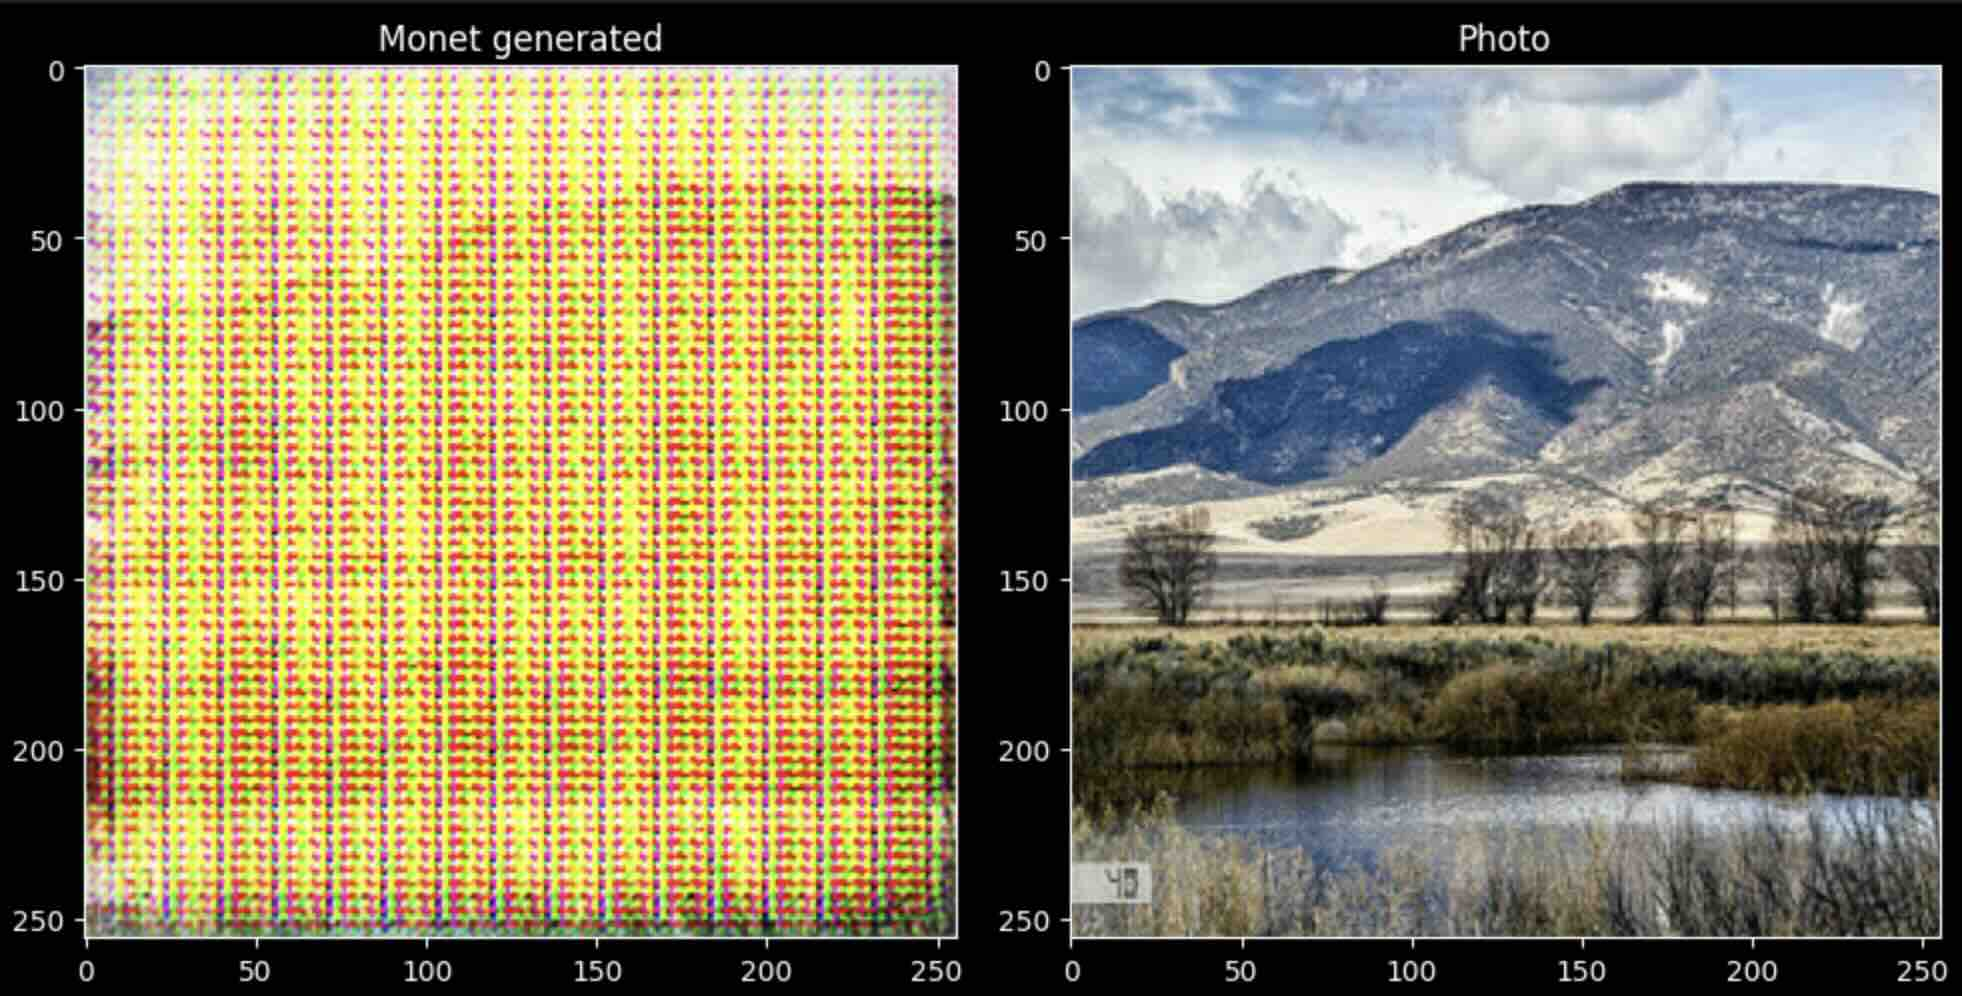
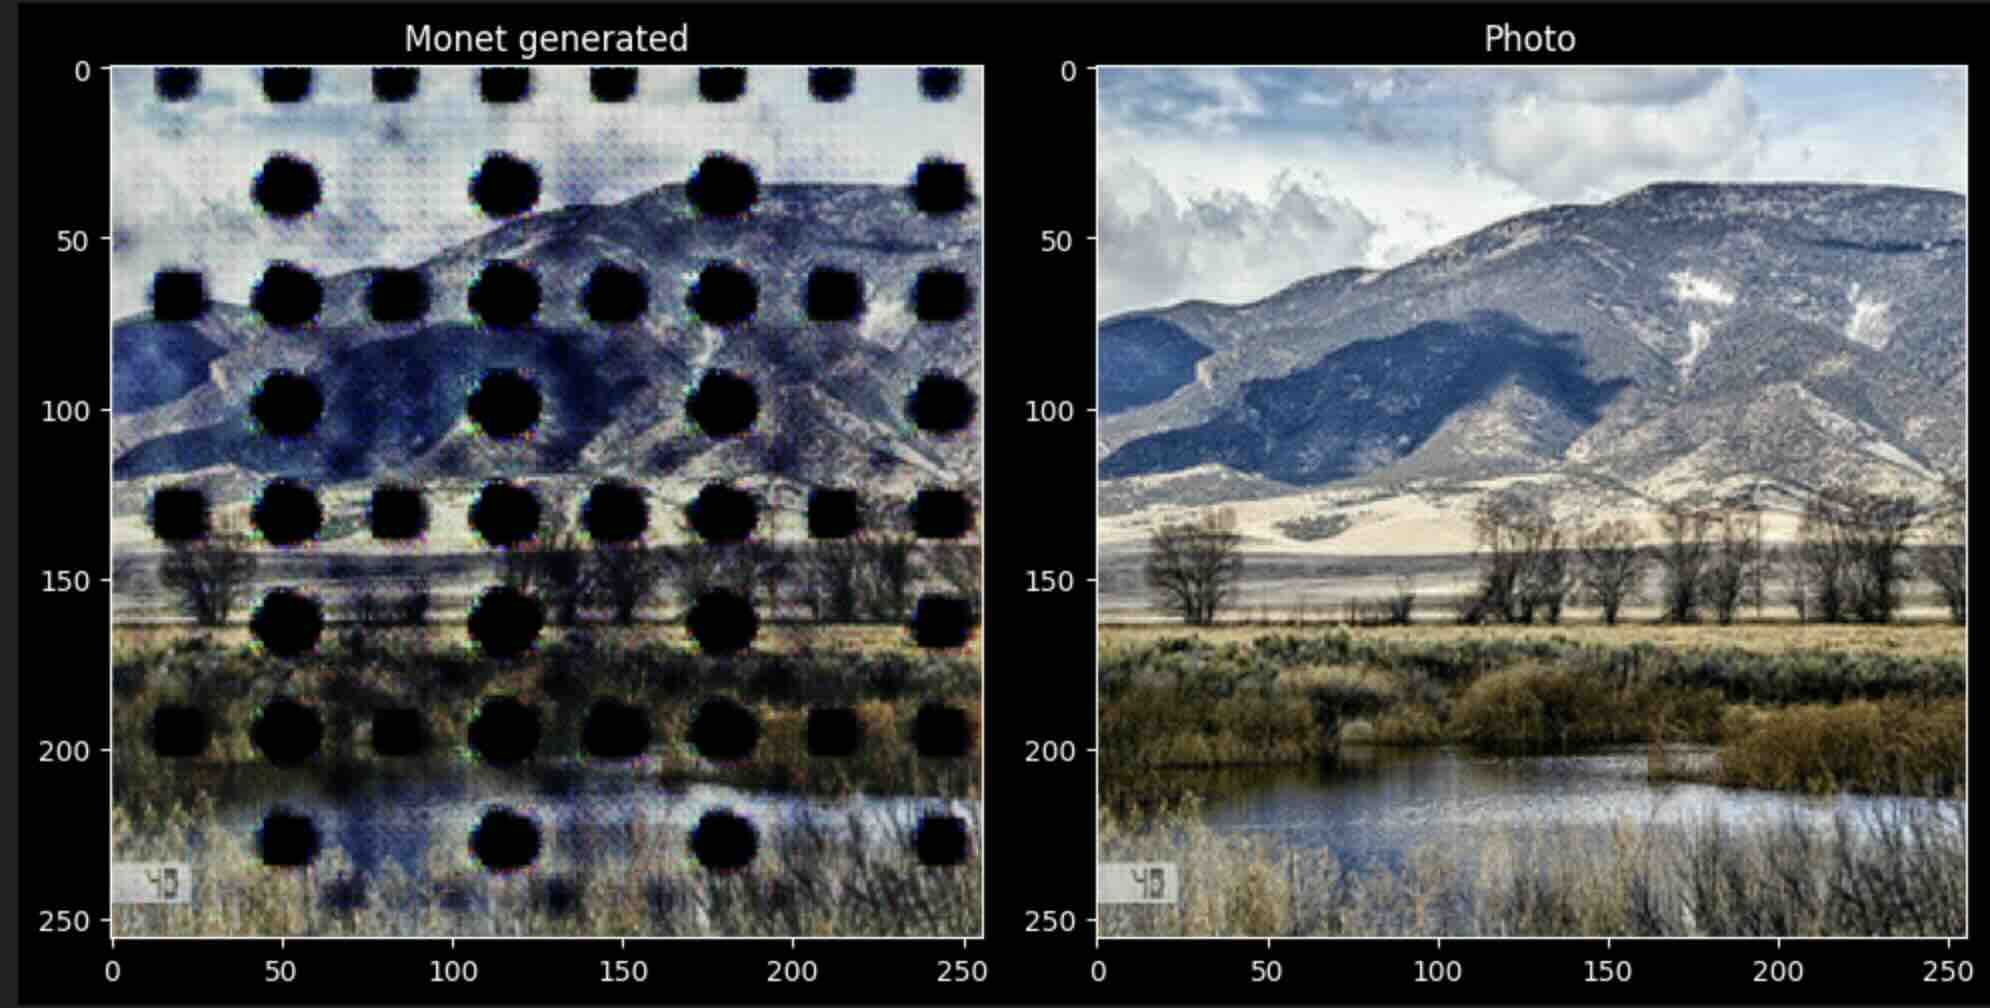

In [30]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=50
)


Epoch 1/50


I0000 00:00:1713012445.619725      93 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 163s 146ms/step - monet_disc_loss: 0.6349 - monet_gen_loss: 4.3219 - photo_disc_loss: 0.6195 - photo_gen_loss: 4.4100 - loss: 0.0000e+00
Epoch 2/50
  1/300 ━━━━━━━━━━━━━━━━━━━━ 52s 174ms/step - monet_disc_loss: 0.6663 - monet_gen_loss: 3.4788 - photo_disc_loss: 0.5490 - photo_gen_loss: 3.8861

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 146ms/step - monet_disc_loss: 0.6093 - monet_gen_loss: 3.2042 - photo_disc_loss: 0.6078 - photo_gen_loss: 3.2623 - loss: 0.0000e+00
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 146ms/step - monet_disc_loss: 0.6209 - monet_gen_loss: 2.9582 - photo_disc_loss: 0.6152 - photo_gen_loss: 3.0168 - loss: 0.0000e+00
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 146ms/step - monet_disc_loss: 0.6121 - monet_gen_loss: 2.8338 - photo_disc_loss: 0.6099 - photo_gen_loss: 2.8793 - loss: 0.0000e+00
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 146ms/step - monet_disc_loss: 0.6073 - monet_gen_loss: 2.7626 - photo_disc_loss: 0.6066 - photo_gen_loss: 2.8061 - loss: 0.0000e+00
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 146ms/step - monet_disc_loss: 0.6069 - monet_gen_loss: 2.7103 - photo_disc_loss: 0.6031 - photo_gen_loss: 2.7640 - loss: 0.0000e+00
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 146ms/step - monet_disc_loss: 0.6069 - monet_gen_loss: 2.6746 - photo_disc_loss: 0.6014

In [48]:
def plot_images_real_vs_generated(number=3):
    fig, axes = plt.subplots(number, 2, figsize=(10, 10))
    photo_iter = iter(photo_ds)
    skip_first = next(photo_iter)
    for i in range(number):
        image = next(photo_iter)
        monet_gen_image = monet_generator(image, training=False)[0].numpy()
        monet_gen_image = (monet_gen_image * 127.5 + 127.5).astype(np.uint8)
        real_photo = (image[0] * 0.5 + 0.5)
        
        axes[i, 0].imshow(real_photo)
        axes[i, 0].set_title('Photo')
        axes[i, 1].imshow(monet_gen_image)
        axes[i, 1].set_title('Monet generated')
        #i += 1
    plt.style.use('dark_background')
    plt.tight_layout()
    plt.show()    

## Results and Analysis:
After 50 epochs I can se that the model has learn some of the style and I can see the resemble to Monet's work. 
The model trained for elements: the monet generator, the monet discriminator, the photo generator and the photo discriminator.
The losses were a lot lower for the discriminators than those of the generators. We can interpret that the discriminators dominated the model. 

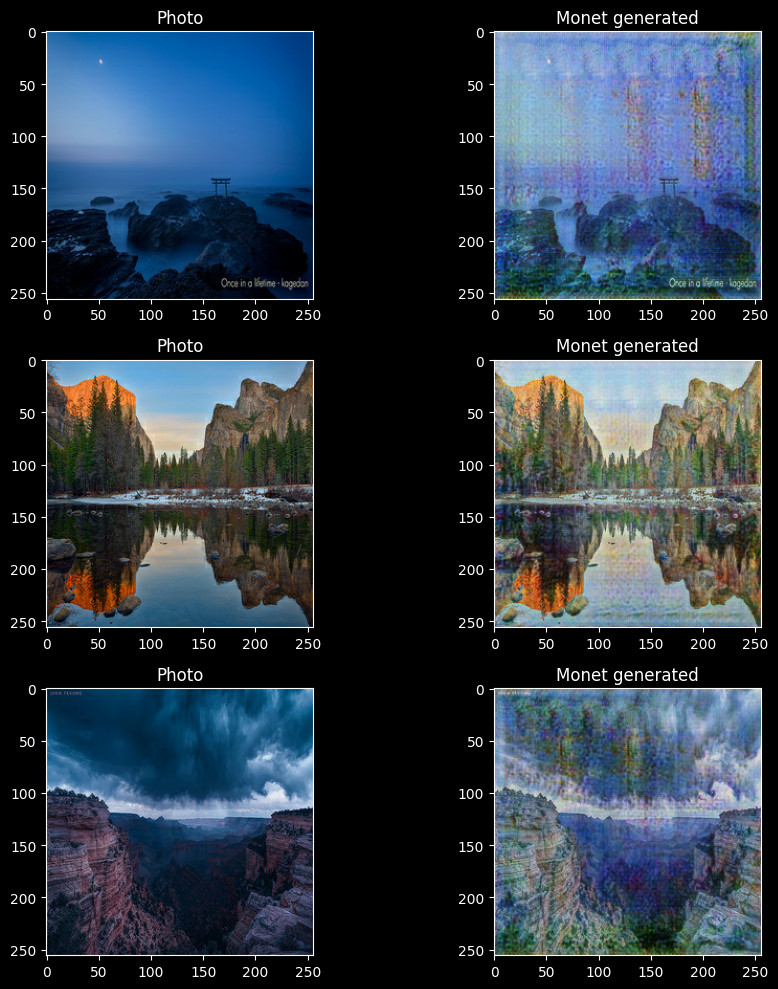

In [49]:
plot_images_real_vs_generated()

In [56]:
from PIL import Image
import zipfile

In [52]:
!mkdir ../tmp

In [95]:
def save_to_jpeg():
    index = 1
    photo_iter = iter(photo_ds)
    for photo in photo_ds:
        image = next(photo_iter)
        gen_image = monet_generator(image, training=False)[0].numpy()
        gen_image = (gen_image * 127.5 + 127.5).astype(np.uint8)
        output_image = Image.fromarray(gen_image)
        output_image.save('../tmp/' + str(index) + ".jpg")
        index += 1

        
def zip_files(files):
    with zipfile.ZipFile("images.zip", "w") as zipf:
        for filename in files:
            zipf.write(filename, os.path.basename(filename))

In [100]:
save_to_jpeg()
images_zip_path = "../tmp/*.jpg"
filenames = tf.io.gfile.glob(images_zip_path)
zip_files(filenames)

## Conclusion, lessons learn and further work

### Conclusion:
* The cycle GAN managed to learn the "style" of the pictures without having to get similar pictures with different styles. 
* The networks are very sensitive to the type of the normalization one use. I used first Batch normalization and my pictures got horrible black spots at regular intervals. I can still see in some pictures some kind of noise at regular intervals
* Take your time when working with pictures

### Lessons learn: 
* Working with pictures is more difficult than working with text. It is more resource hungry. I made an atempt to use TPU, but the environment had problems with some packages
* Conv2DTranspose layer was unknown to me. I read about it here: https://www.geeksforgeeks.org/tensorflow-js-tf-layers-conv2dtranspose-function/
* It was very good to work with customized training steps and custom metrics for losses and several losses at the same time

### Further work:
* Try other painters! Edvard Munch could be good one 
* Make a custom callback that in fact saves the values of each of the custom losses to the history object so one can plot the values and compare easily
* Try other architectures instead of transpose convolutional layer, try to get the upsampling and normal convolutional network to work properly. It is supposed to help to avoid the noise in the generated pictures
